In [1]:
# Imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Internal import (this repo must be installed as package)
from market_regime.labeling import make_regime_labels

# Global variables
REPO_DIR: Path = Path("..").resolve()
assert REPO_DIR.name == "market-regime-classification", "`REPO_DIR` points to incorrect folder."
RAW_DATA_PATH: Path = REPO_DIR / "data/raw"

In [2]:
# Load data
df = pd.read_csv(RAW_DATA_PATH / "daily_prices.csv")
df["trading_date"] = pd.to_datetime(df["trading_date"], format="%Y-%m-%d")
df["delivery_date"] = pd.to_datetime(df["delivery_date"], format="%Y-%m-%d")
df = df.set_index("trading_date").sort_index()

# Calculate log returns
df[["open_t", "close_t"]] = df[["open", "close"]].copy()
df["close_t-1"] = df.groupby("delivery_date")["close_t"].shift(1).fillna(df["open_t"])
df["log_return_t"] = np.log(df["close_t"] / df["close_t-1"])

# Calculate standarized log returns (sharpe ratio) for window_len days into future
for window_len in [5, 10, 20]:
    df[f"log_return_t-{window_len-1}:t"] = df["log_return_t"].rolling(window=window_len, min_periods=window_len, center=False).sum()
    df[f"log_return_t+1:t+{window_len}"] = df[f"log_return_t-{window_len-1}:t"].shift(-window_len)
    df[f"volatility_t-{window_len-1}:t"] = df["log_return_t"].rolling(window=window_len, min_periods=window_len, center=False).std() * np.sqrt(window_len)
    df[f"volatility_t+1:t+{window_len}"] = df[f"volatility_t-{window_len-1}:t"].shift(-window_len)

    df[f"sharpe_ratio_{window_len}"] = df[f"log_return_t+1:t+{window_len}"] / df[f"volatility_t+1:t+{window_len}"]

,sharpe_ratio_5,sharpe_ratio_10,sharpe_ratio_20
count,2362.000000,2357.000000,2347.000000
mean,-0.049927,-0.078564,-0.075581
std,1.370718,1.215419,1.199031
min,-9.899373,-4.915901,-3.448336
25%,-0.847935,-0.838396,-0.921076
50%,-0.085891,-0.087319,-0.064875
75%,0.691493,0.676419,0.705721
max,9.799656,4.396857,4.643171


<Axes: ylabel='Count'>

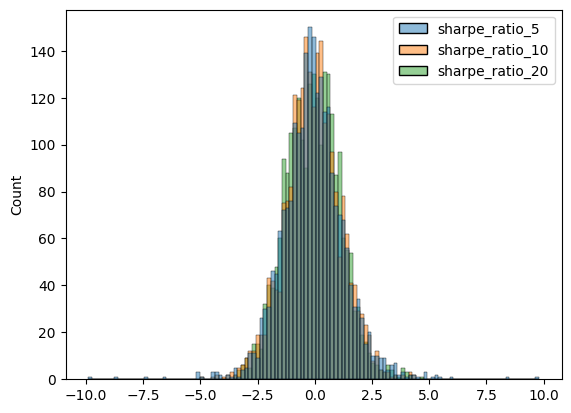

In [3]:
display(df.filter(like="sharpe_ratio").describe())
sns.histplot(df.filter(like="sharpe_ratio"))

<Axes: xlabel='sharpe_ratio_20', ylabel='Count'>

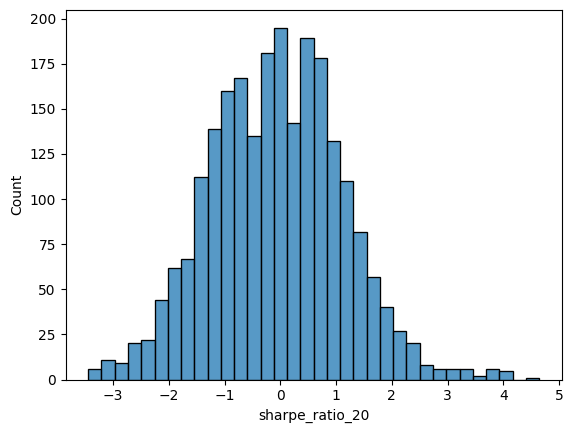

In [ ]:
# 20 dni w przod wydaje sie sensownym wyborem: jest to okolo miesiac kalendarzowy 
sns.histplot(df["sharpe_ratio_20"])     # type:ignore

target
-1.0    0.364425
 0.0    0.332321
 1.0    0.303254
Name: proportion, dtype: float64

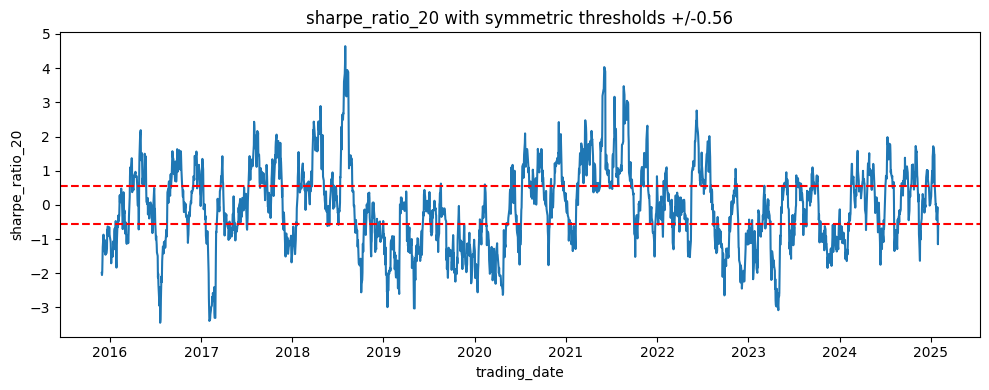

In [5]:
# Calculate target
target, k = make_regime_labels(
    df, window_len=20, delivery_date_cutoff=pd.Timestamp("2025-01-01")
)
df = df.drop(columns="target", errors="ignore")
df = df.join(target)

display(df["target"].value_counts(normalize=True).sort_index())

col = "sharpe_ratio_20"
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x=df.index, y=df[col], ax=ax)
ax.axhline(y=k, color="red", linestyle="--")
ax.axhline(y=-k, color="red", linestyle="--")
ax.set_xlabel("trading_date")
ax.set_ylabel(col)
ax.set_title(f"{col} with symmetric thresholds +/-{k}")
plt.tight_layout()
plt.show()